# Matteo Caiola               
# Lorenzo Cusin
# Giacomo Serafini
# Andrea Tonello 

# Dataset


The pathology and hematology departments at Libya's Sebha Oncology Center; embody the spatial boundaries of a study. The information was gathered from BC cases that were recorded at the center between 2015 and 2020, Which represents the time limits of the study. The inclusion criteria were all Libyan cases from different regions who were registered during the study at the SOC.

Biomarkers and tumor markers are molecules used to detect the presence of cancer, monitor it, and evaluate its response to treatment. In the case of breast cancer, these markers could be proteins, genes, or their products that are found in abnormal levels in the body.

#### The role of biomarkers in diagnosing breast cancer:

##### 1) Early detection: Vital signs help detect cancer in its early stages, which increases the chances of successful treatment.
##### 2) Diagnosis: Some vital signs can be used to determine the type of breast cancer and its stages of development.
##### 3)Treatment evaluation: It helps evaluate the effectiveness of the ongoing treatment and monitor the progression of the disease.
* Examples of biomarkers used in breast cancer:
**

CA 15-3 and CA 27.29: These are proteins found in elevated levels in some types of breast cancer, and are used to monitor treatment.
HER2: A protein on the surface of breast cancer cells. Its presence in large quantities indicates a type of cancer that can be treated with certain medications.
ER and PR: They express hormone receptors (estrogen and progesterone). Its presence helps guide hormonal treatment.
BRCA1 and BRCA2: Genes that, if mutated, increase the risk of breast cancer and help in making prevention and treatment decisions.**
Using these signs can provide accurate information about a patient's condition, helping doctors provide the most appropriate treatment for each case.

In [1]:
import pandas as pd

In [3]:

file_path = 'BC.csv'
data = pd.read_csv(file_path)


data.head()


,Sex,Age,Adress,FBS,Urea,Creatinin,ALB,T_Ca,GPT,GOT,...,WBC,RBC,HGB,PLT,ESR,LDH,Na,K,CL,CLASS
0,1,60,Tragan,100,23,0.8,3.4,10.0,20,10,...,3.4,4.60,13.4,196,14,150,145.0,4.50,107.1,0
1,1,53,Sabha,190,27,0.6,4.2,9.3,11,17,...,4.4,5.00,12.5,155,15,260,139.2,4.17,106.4,0
2,1,50,Sabha,150,15,1.1,3.5,8.5,13,10,...,5.1,4.46,13.8,312,15,169,140.0,4.00,100.1,0
3,1,36,Obaree-center,80,20,1.0,4.2,8.0,7,13,...,3.1,4.33,10.7,212,10,138,136.4,4.06,107.1,0
4,1,30,Obaree-center,80,40,0.8,3.0,9.5,9,15,...,4.2,4.13,12.3,243,5,154,142.3,4.00,106.2,0


In [3]:
# Dataset
data = pd.read_csv("BC.csv")

Model: Logistic Regression
Accuracy: 0.9466
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       406
           1       0.96      0.92      0.94       325

    accuracy                           0.95       731
   macro avg       0.95      0.94      0.95       731
weighted avg       0.95      0.95      0.95       731

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.9685
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       406
           1       0.97      0.96      0.96       325

    accuracy                           0.97       731
   macro avg       0.97      0.97      0.97       731
weighted avg       0.97      0.97      0.97       731

--------------------------------------------------
Model: Random Forest
Accuracy: 0.9836
Classification Report:
              precision    recall  f1-score   support



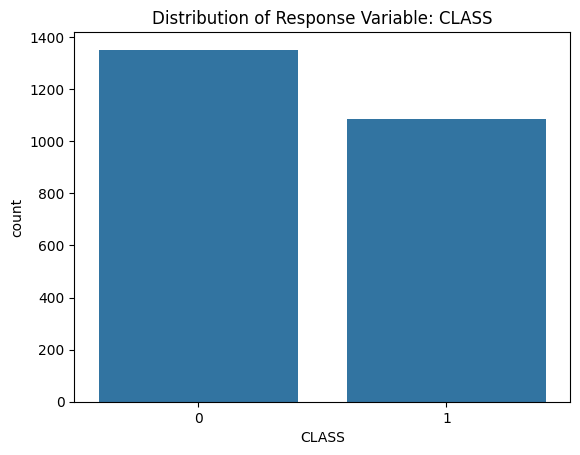

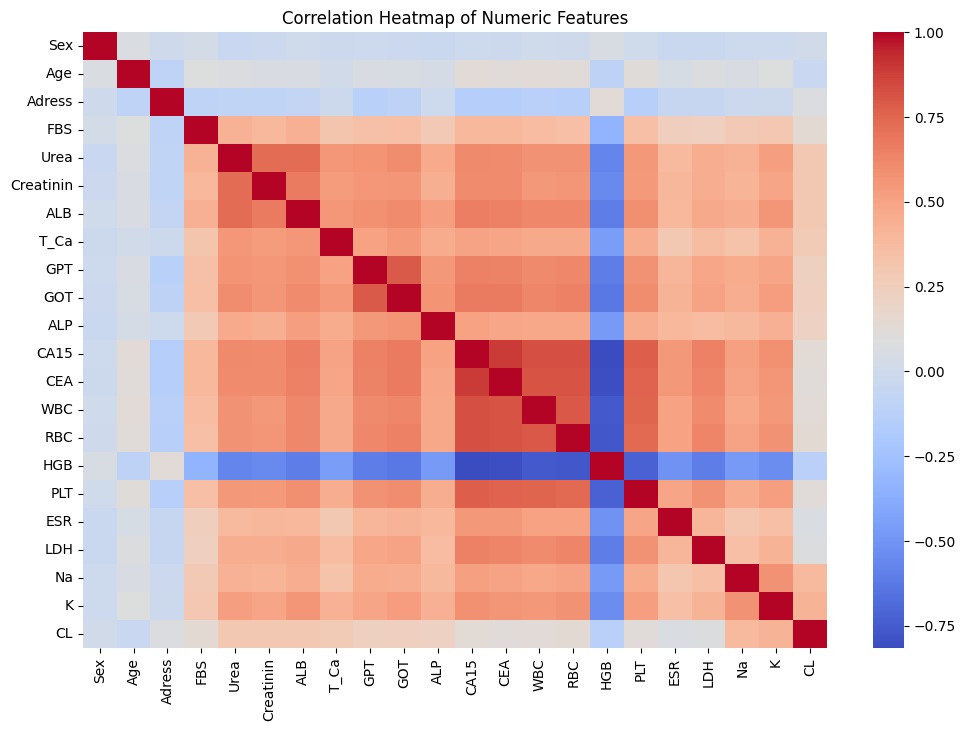

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('BC.csv')

# Encode the 'Adress' categorical feature
label_encoder = LabelEncoder()
data['Adress'] = label_encoder.fit_transform(data['Adress'])

# Standardize numerical features
numeric_features = data.select_dtypes(include=['int64', 'float64']).drop(columns=['CLASS'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)
scaled_data = pd.DataFrame(scaled_features, columns=numeric_features.columns)

# Add the CLASS column back for modeling
scaled_data['CLASS'] = data['CLASS']

# Split the dataset into training and testing sets
X = scaled_data.drop(columns=['CLASS'])
y = scaled_data['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, zero_division=0)
    }

# Display results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Classification Report:")
    print(metrics['classification_report'])
    print("-" * 50)

# Optional: Visualize distribution of CLASS variable
sns.countplot(x='CLASS', data=data)
plt.title('Distribution of Response Variable: CLASS')
plt.show()

# Optional: Heatmap of feature correlations
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()
